### Fauna Image Classification using Convolutional Neural Network

importing necessary libraries

In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math  
import datetime
import time

Using TensorFlow backend.


Looking up our image dataset

In [2]:
#Default dimensions 
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 7

# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [3]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

Creation of weights/features with VGG16

In [5]:
#run this only once
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
train_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode=None,
shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 13412 images belonging to 6 classes.
Time:  1:36:47.855138


In [6]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 2549 images belonging to 6 classes.
Time:  0:17:32.267965


In [7]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
nb_test_samples = len(generator.filenames)  
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)  
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1845 images belonging to 6 classes.
Time:  0:15:12.725195


Loading training, validation and testing data

In [8]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 13412 images belonging to 6 classes.


In [9]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 2549 images belonging to 6 classes.


In [10]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   
test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1845 images belonging to 6 classes.


Training of model

In [11]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

C:\Users\KAVISH\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 13412 samples, validate on 2549 samples
Epoch 1/7
13412/13412 [==============================] - 16s 1ms/step - loss: 0.7417 - acc: 0.7441 - val_loss: 0.3621 - val_acc: 0.8752
Epoch 2/7
13412/13412 [==============================] - 10s 771us/step - loss: 0.4148 - acc: 0.8599 - val_loss: 0.3121 - val_acc: 0.8996
Epoch 3/7
13412/13412 [==============================] - 11s 791us/step - loss: 0.3331 - acc: 0.8888 - val_loss: 0.2704 - val_acc: 0.9109
Epoch 4/7
13412/13412 [==============================] - 10s 781us/step - loss: 0.2798 - acc: 0.9081 - val_loss: 0.2678 - val_acc: 0.9145
Epoch 5/7
13412/13412 [==============================] - 10s 757us/step - loss: 0.2405 - acc: 0.9197 - val_loss: 0.3121 - val_acc: 0.9019
Epoch 6/7
13412/13412 [==============================] - 10s 754us/step - loss: 0.2118 - acc: 0.9264

In [12]:
#Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2508900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 306       
Total params: 2,514,256
Trainable params: 2,514,256
Non-trainable params: 0
_________________________________________________________________


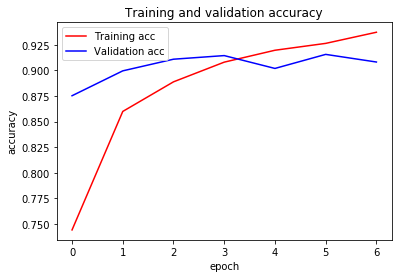

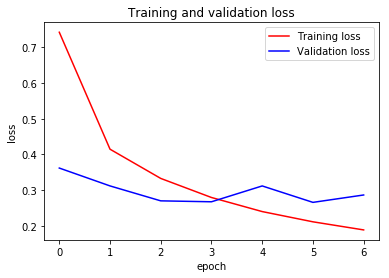

In [13]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

Model Evaluation on Testing Set

In [14]:
model.evaluate(test_data, test_labels)

1845/1845 [==============================] - 0s 255us/step


[0.29896350955252404, 0.9062330624275414]

Classification metrics

In [15]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[ 1.62910089e-01 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     7.54944324e-01 -0.00000000e+00]
   [ 9.73954201e-02 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     6.17595196e-01 -0.00000000e+00]
   [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     4.81749594e-01 -0.00000000e+00]
   ...
   [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     4.90738869e-01 -0.00000000e+00]
   [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     4.19955850e-01 -0.00000000e+00]
   [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     5.68091154e-01 -0.00000000e+00]]

  [[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
     5.71550667e-01 -0.00000000e+00]
   [-0.00000000e+00 -0.00000000e+00  2.10543394e-01 ... -0.00000000e+00
     3.51710498e-01 -0.00000000e+00]
   [-0.00000000e+00 -0.00000000e+00  6.56101465e-01 ... -0.00000000e+00
     1.31017476e-01 -0.00000000e+00]


rounded test_labels [[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


In [16]:
animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

 butterflies       0.98      0.86      0.92       371
    chickens       0.94      0.87      0.90       203
   elephants       0.91      0.86      0.88       152
      horses       0.99      0.88      0.93       472
     spiders       0.83      0.98      0.90       403
   squirells       0.89      0.91      0.90       244

   micro avg       0.92      0.90      0.91      1845
   macro avg       0.92      0.89      0.91      1845
weighted avg       0.93      0.90      0.91      1845
 samples avg       0.90      0.90      0.90      1845



C:\Users\KAVISH\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Confusion Matrix

In [17]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
#label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [18]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [19]:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
#Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


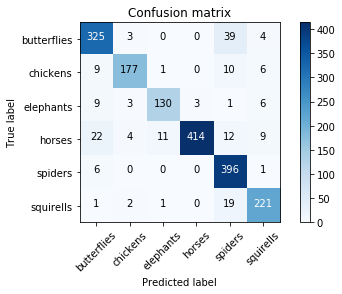

In [20]:
plot_confusion_matrix(confusion_matrix, ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells'])

Normalized confusion matrix


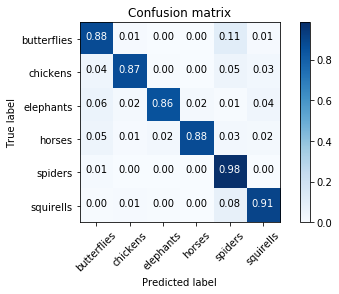

In [21]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells'],
                     normalize=True)

Testing images on model

In [22]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [23]:
def test_single_image(path):
    animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict_proba(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [24]:
#path of image that is used for testing
path = 'data/test/testimage.jpeg'

[INFO] loading and preprocessing image...
ID: 0, Label: butterflies 99.96%
ID: 1, Label: chickens 0.0%
ID: 2, Label: elephants 0.0%
ID: 3, Label: horses 0.0%
ID: 4, Label: spiders 0.03%
ID: 5, Label: squirells 0.0%
Final Decision:
.
..
...
ID: 0, Label: butterflies


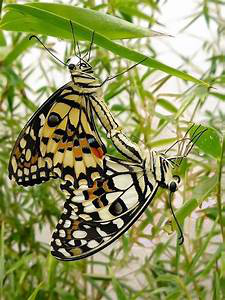

In [25]:
test_single_image(path)